In [1]:
from google.colab import files
uploaded = files.upload()

Saving CVC-ClinicDB.rar to CVC-ClinicDB.rar


In [2]:
!apt-get install unrar
import os
rar_file = "/content/CVC-ClinicDB.rar"
output_dir = "/content/CVC-ClinicDB"


os.makedirs(output_dir, exist_ok=True)


!unrar x -o+ "{rar_file}" "{output_dir}"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/CVC-ClinicDB.rar

Creating    /content/CVC-ClinicDB/CVC-ClinicDB                        OK
Creating    /content/CVC-ClinicDB/CVC-ClinicDB/Ground Truth           OK
Extracting  /content/CVC-ClinicDB/CVC-ClinicDB/Ground Truth/1.tif          0%  OK 
Extracting  /content/CVC-ClinicDB/CVC-ClinicDB/Ground Truth/10.tif         0%  OK 
Extracting  /content/CVC-ClinicDB/CVC-ClinicDB/Ground Truth/100.tif        0%  OK 
Extracting  /content/CVC-ClinicDB/CVC-ClinicDB/Ground Truth/101.tif        0%  OK 
Extracting  /content/CVC-ClinicDB/CVC-ClinicDB/Ground Truth/102.tif        0%  OK 
Extracting  /content/CVC-ClinicDB/CVC-ClinicDB/Ground Truth/103.t

In [3]:
import os
import torch
base_dir = "CVC-ClinicDB/CVC-ClinicDB"
groundTruth_dir = os.path.join(base_dir, "Ground Truth")
original_dir = os.path.join(base_dir, "Original")


if os.path.exists(groundTruth_dir) and os.path.exists(original_dir):
    image_files = os.listdir(groundTruth_dir)
    mask_files = os.listdir(original_dir)

    print(f"Number of images: {len(image_files)}")
    print(f"Number of masks: {len(mask_files)}")
else:
    print(f"Either {groundTruth_dir} or {original_dir} does not exist!")

Number of images: 612
Number of masks: 612


In [11]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


base_dir = "CVC-ClinicDB/CVC-ClinicDB"
images_dir = os.path.join(base_dir, "Original")
masks_dir = os.path.join(base_dir, "Ground Truth")


IMG_SIZE = (224, 224)
BATCH_SIZE = 16


print("Images directory contents:", os.listdir(images_dir)[:5])
print("Masks directory contents:", os.listdir(masks_dir)[:5])

image_paths = sorted([os.path.join(images_dir, fname) for fname in os.listdir(images_dir) if fname.endswith(".tif")])
mask_paths = sorted([os.path.join(masks_dir, fname) for fname in os.listdir(masks_dir) if fname.endswith(".tif")])


assert len(image_paths) == len(mask_paths), "image mark not equal！"
print(f"Found {len(image_paths)} images and {len(mask_paths)} masks.")


train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)
print(f"Training images: {len(train_images)}, Validation images: {len(val_images)}")


class CVCClinicDataset(Dataset):
    def __init__(self, images, masks, transform=None, target_transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(self.images[idx], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)


        image = cv2.resize(image, IMG_SIZE)
        mask = cv2.resize(mask, IMG_SIZE)


        image = image / 255.0
        mask = (mask > 127).astype(np.float32)


        if self.transform:
            image = self.transform(image).to(torch.float32)
        if self.target_transform:
            mask = self.target_transform(mask).to(torch.float32)

        return image, mask



image_transform = transforms.Compose([
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset = CVCClinicDataset(train_images, train_masks, transform=image_transform, target_transform=mask_transform)
val_dataset = CVCClinicDataset(val_images, val_masks, transform=image_transform, target_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


for images, masks in train_loader:
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    break

Images directory contents: ['449.tif', '548.tif', '245.tif', '544.tif', '249.tif']
Masks directory contents: ['449.tif', '548.tif', '245.tif', '544.tif', '249.tif']
Found 612 images and 612 masks.
Training images: 489, Validation images: 123
Image batch shape: torch.Size([16, 3, 224, 224])
Mask batch shape: torch.Size([16, 1, 224, 224])


In [5]:
from transformers import ConvNextModel, ConvNextConfig


convnext_config = ConvNextConfig.from_pretrained("facebook/convnext-tiny-224")
backbone = ConvNextModel.from_pretrained("facebook/convnext-tiny-224", config=convnext_config)

print("ConvNeXt backbone loaded successfully!")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/114M [00:00<?, ?B/s]

ConvNeXt backbone loaded successfully!


In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class ConvNeXtSegmentationModel(nn.Module):
    def __init__(self, backbone, num_classes=2):
        super(ConvNeXtSegmentationModel, self).__init__()
        self.backbone = backbone
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(768, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):

        features = self.backbone(x).last_hidden_state


        seg_map = self.upsample(features)
        seg_map = nn.functional.interpolate(
            seg_map, size=(224, 224), mode="bilinear", align_corners=False
        )
        return seg_map


Using device: cuda


In [7]:
import torch
import torch.nn as nn

def fine_tune_model(model, train_loader, val_loader, num_epochs=10, learning_rate=5e-4, device=None):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)


    train_losses = []
    val_ious = []

    for epoch in range(num_epochs):

        model.train()
        total_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.squeeze(1).long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_train_loss:.4f}")

        model.eval()
        total_iou = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.squeeze(1).long().to(device)
                outputs = model(images)
                predictions = torch.argmax(outputs, dim=1)
                iou = calculate_iou(predictions, masks)
                total_iou += iou

        avg_val_iou = total_iou / len(val_loader)
        val_ious.append(avg_val_iou)
        print(f"Validation IoU: {avg_val_iou:.4f}")

    return model, train_losses, val_ious


def calculate_iou(pred_mask, true_mask):

    pred_mask = pred_mask.cpu().numpy()
    true_mask = true_mask.cpu().numpy()
    intersection = (pred_mask & true_mask).sum()
    union = (pred_mask | true_mask).sum()
    return intersection / union if union > 0 else 0.0



In [8]:
def visualize_training_results(train_losses, val_ious):

    if isinstance(train_losses[0], torch.Tensor):
        train_losses = [loss.cpu().item() for loss in train_losses]
    if isinstance(val_ious[0], torch.Tensor):
        val_ious = [iou.cpu().item() for iou in val_ious]

    epochs = range(1, len(train_losses) + 1)


    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_ious, marker='o', color='green', label='Validation IoU')
    plt.title('Validation IoU Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()


    plt.tight_layout()
    plt.show()


In [9]:
def calculate_metrics(predictions, targets):

    intersection = (predictions & targets).sum().float()
    union = (predictions | targets).sum().float()
    true_positive = intersection
    false_positive = (predictions & ~targets).sum().float()
    false_negative = (~predictions & targets).sum().float()

    # IoU
    iou = (intersection / union) if union > 0 else 0.0
    # Precision
    precision = (true_positive / (true_positive + false_positive)) if (true_positive + false_positive) > 0 else 0.0
    # Recall
    recall = (true_positive / (true_positive + false_negative)) if (true_positive + false_negative) > 0 else 0.0
    # F1-Score
    f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    return iou, precision, recall, f1_score


def inference_and_evaluate(model, val_loader, device=None):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)
    model.eval()

    total_iou = 0.0
    total_precision = 0.0
    total_recall = 0.0
    total_f1_score = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.squeeze(1).long().to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1).bool()
            masks = masks.bool()


            iou, precision, recall, f1_score = calculate_metrics(predictions, masks)
            total_iou += iou
            total_precision += precision
            total_recall += recall
            total_f1_score += f1_score


    num_batches = len(val_loader)
    avg_iou = total_iou / num_batches
    avg_precision = total_precision / num_batches
    avg_recall = total_recall / num_batches
    avg_f1_score = total_f1_score / num_batches


    print(f"Final IoU: {avg_iou:.4f}")
    print(f"Final Precision: {avg_precision:.4f}")
    print(f"Final Recall: {avg_recall:.4f}")
    print(f"Final F1-Score: {avg_f1_score:.4f}")

    return avg_iou, avg_precision, avg_recall, avg_f1_score




Epoch 1/40, Loss: 0.2459
Validation IoU: 0.0000
Epoch 2/40, Loss: 0.1299
Validation IoU: 0.0000
Epoch 3/40, Loss: 0.1004
Validation IoU: 0.6147
Epoch 4/40, Loss: 0.0874
Validation IoU: 0.5940
Epoch 5/40, Loss: 0.0725
Validation IoU: 0.7694
Epoch 6/40, Loss: 0.0395
Validation IoU: 0.8101
Epoch 7/40, Loss: 0.0285
Validation IoU: 0.7836
Epoch 8/40, Loss: 0.0220
Validation IoU: 0.8128
Epoch 9/40, Loss: 0.0183
Validation IoU: 0.8160
Epoch 10/40, Loss: 0.0164
Validation IoU: 0.8214
Epoch 11/40, Loss: 0.0137
Validation IoU: 0.8252
Epoch 12/40, Loss: 0.0123
Validation IoU: 0.8234
Epoch 13/40, Loss: 0.0122
Validation IoU: 0.8271
Epoch 14/40, Loss: 0.0111
Validation IoU: 0.8200
Epoch 15/40, Loss: 0.0105
Validation IoU: 0.8241
Epoch 16/40, Loss: 0.0097
Validation IoU: 0.8252
Epoch 17/40, Loss: 0.0101
Validation IoU: 0.8211
Epoch 18/40, Loss: 0.0094
Validation IoU: 0.8204
Epoch 19/40, Loss: 0.0088
Validation IoU: 0.8292
Epoch 20/40, Loss: 0.0081
Validation IoU: 0.8282
Epoch 21/40, Loss: 0.0075
Val

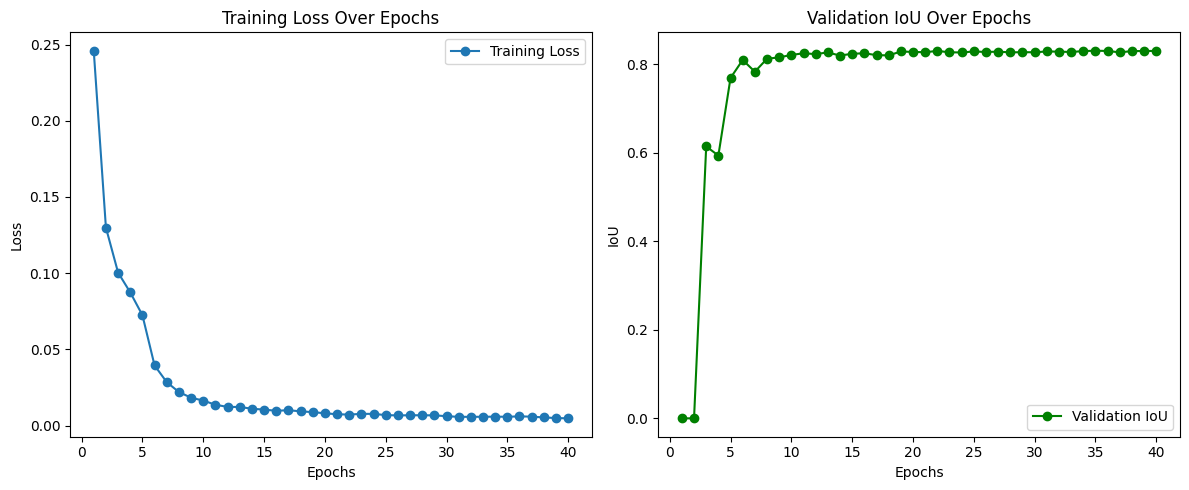

Final IoU: 0.8306
Final Precision: 0.9115
Final Recall: 0.9028
Final F1-Score: 0.9062


(tensor(0.8306, device='cuda:0'),
 tensor(0.9115, device='cuda:0'),
 tensor(0.9028, device='cuda:0'),
 tensor(0.9062, device='cuda:0'))

In [12]:

model = ConvNeXtSegmentationModel(backbone)

fine_tuned_model, train_losses, val_ious = fine_tune_model(
    model, train_loader, val_loader, num_epochs=40, learning_rate=5e-4
)

visualize_training_results(train_losses, val_ious)
inference_and_evaluate(fine_tuned_model, val_loader)
